In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import math
import random
import numpy as np
import gymnasium as gym
# from robot_model import *
torch.manual_seed(42)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)
# device = 'cpu'

In [2]:
params = {
    'cables':4,
    'A1':torch.tensor([-1.154, -1.404, 3.220]).float().to(device),
    'A2':torch.tensor([1.154, -1.404, 3.220]).float().to(device),
    'A3':torch.tensor([1.154, 1.404, 3.220]).float().to(device),
    'A4':torch.tensor([-1.154, 1.404, 3.220]).float().to(device),
    'l1':1000.0, # servos are 1m lower than anchor points
    'l2':1000.0, # the initial length of each cable is 1m
    'l3':1000.0,
    'l4':1000.0,
    'drums_r':0.05, # m
    'cable_gage':0.003, # m
    'drums_w':1, #m
    'initial_phis':torch.tensor([100.0, 100.0, 100.0, 100.0]).float().to(device), # rads at [0,0,0] position of end-effector
    'initial_ls':torch.tensor([3.697, 3.697, 3.697, 3.697]).float().to(device), # [mm], A_i to  end-effector initial length
    'box':torch.tensor([0.5, 0.5, 0.5]).float().to(device),
    'r':0.025 # [mm] radius of pulley
}

g=9.81

In [3]:
class CDPR4_torch:
    def __init__(self, pos, params=params, approx=1, mass=1):
        self.params = params # anchor points
        self.approx = approx # check folder /maths_behind_cdpr for approximations description
        self.pos = pos.float().to(device)
        self.m = mass # mass of a load
        self.dt = 0.005
        self.v = torch.tensor([0,0,0]).float().to(device) # end effector velocity
        self.a = 0 # end effector acceleration
        self.Kp = 1
        self.Kd = 1
        self.t_f = 5 # sec
        
    def jacobian(self):
        J = torch.zeros((4,3)).to(device)
        
        for i in range(4):
            c_ai = self.pos - self.params[f'A{i+1}']
            li = torch.linalg.norm(c_ai)# len
            J[i, :] = c_ai/li
        return J
    
    def B(self):
        B = torch.zeros((6,4))
        
        lower_rows = -(1/self.m)*self.jacobian().T
        
        B[3:6, :] = lower_rows
        return B

        

In [4]:
#TODO: rebuild whole code such I have 2 actions for each actuator, pull with force 45N or not pull (0N)

from gymnasium import spaces

class CDPR4_DQN_env(CDPR4_torch):
    def __init__(self, start_state=torch.tensor([.0, .0, 1.0, .0, .0, .0]).float(), desired_state=torch.tensor([.0, .0, 2.0, .0, .0, .0]), pos=torch.tensor([.0, .0, 1.0]).float().to(device), params=params, approx=1, mass=1):
        super().__init__(pos=torch.tensor([.0, .0, 1.]).float().to(device), params=params, approx=1, mass=1)

        self.start_state = start_state.float().to(device)  # start position 1m on Z
        self.cur_state = torch.tensor([.0, .0, 1., .0, .0, .0]).float().to(device) # X=[pos, vel] in control
        self.reward = 0 # reward 0 is 0 error in position, closer position to desired -> higher reward 
        self.desired_state = desired_state.float().to(device)
        self.v = torch.tensor([.0, .0, .0]).float().to(device)
    
        self.max_speed = 10
        self.max_force = 10 
        
        self.action_space = spaces.MultiDiscrete(np.array([[2], [2], [2], [2]]))
        self.observation_space = spaces.Box(low=np.array([-1.154, -1.404, .0, -self.max_speed, -self.max_speed, -self.max_speed]), 
                                            high=np.array([1.154, 1.404, 3.220,  self.max_speed, self.max_speed, self.max_speed]))
        self._max_episode_steps = 500 # default in gymnasium env is 1000
        self._elapsed_steps = 0
        self.dt = 0.05 # seconds between state update
        
    def sample(self):
        return torch.from_numpy(self.action_space.sample()).to(device)
        
    def reset(self):
        state = torch.from_numpy(self.observation_space.sample()).float().to(device)
        
        # self.reward = -1 # 1 meter away from desired position
        self._elapsed_steps = 0
        
        self.pos = state[:3].flatten().to(device)
        self.v = state[3:].flatten().to(device)

        
        self.reward = torch.linalg.norm(self.pos - self.desired_state[:3].flatten()).float()
        
        return state, {}
    
    def step(self, action):
        pos = self.cur_state[:3].flatten().to(device)
        vel = self.cur_state[3:].flatten().to(device)
        m = self.m

        dt = self.dt
        costs = torch.linalg.norm(pos - self.desired_state[:3].flatten()).float() # reward function includes only position, no velocities
        # TODO: add velocity to cost
        # TODO: make reward 4D
        
        # costs += 5e-3*np.linalg.norm(vel - self.desired_state[3:].flatten()) # velocity factor
        # print(f'action {action}')
        
        u = self.max_force*action.reshape((4,1)).float().to(device)
        dXdt = self.B().float().to(device) @ u + torch.tensor([.0, .0, .0, .0, .0, -g]).reshape((6,1)).float().to(device)
        # print(f'u {u}')
        # print(f'B {self.B().shape}')
        # print(f'dXdt {dXdt}')
       
        new_vel = vel + dXdt[3:].flatten()*dt
        # print(f'new vel {new_vel}')
        new_pos = pos + vel*dt + 0.5*dXdt[3:].flatten()*dt**2

        self.pos = new_pos.to(device)
        self.v = new_vel.to(device)

        state = torch.hstack((new_pos, new_vel))
        self.cur_state = state.float()
        # print(f'cur_state {self.cur_state}')
        
        terminated = torch.allclose(self.cur_state, self.desired_state, atol=1e-03) # reached desired position
        
        self._elapsed_steps += 1

        truncated = False
        if self._elapsed_steps >= self._max_episode_steps:
            truncated = True
        
        return state, -costs, terminated, truncated, {} #
        

In [5]:
env = CDPR4_DQN_env()

/Users/damirnurtdinov/miniconda3/envs/cdpr_mujoco/lib/python3.9/site-packages/gymnasium/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [6]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [7]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        # self.layer1 = nn.Linear(n_observations, 128)
        # self.layer2 = nn.Linear(128, 128)
        # self.layer3 = nn.Linear(128, n_actions) # 4 actuators
        # self.layer4 = nn.Tanh()
        self.net = nn.Sequential(
            nn.Linear(n_observations, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
             nn.ReLU(),
            nn.Linear(128, n_actions),
            nn.Tanh() 
        )

    def forward(self, x):
        # x = F.relu(self.layer1(x))
        # x = F.relu(self.layer2(x))
        # x = self.layer3(x)
        return self.net(x)

In [8]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.shape[0] #from 0 to 44
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            # print(f'policy_net(state) {torch.max(policy_net(state).reshape((4,45)), 1).indices.view(4, 1)}')
            # print(f'policy_net(state) {policy_net(state).shape}')
            return torch.max(policy_net(state).reshape((4,1)), 1).indices.view(4, 1)
    else:
        # return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
        return env.sample()

episode_durations = []
episode_rewards = []

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    # plt.plot(durations_t.numpy())
    plt.plot(rewards_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [9]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    # print(f'policy_net(state_batch) {policy_net(state_batch).shape}')
    # print(f'action_batch {action_batch.shape}')
    state_action_values = policy_net(state_batch).gather(1, action_batch.reshape([BATCH_SIZE, 4]))
    # Option 1: Sum the Q-values across actuators
    # state_action_values_aggregated = state_action_values.sum(dim=1, keepdim=True)
    
    # Option 2: Average the Q-values across actuators
    state_action_values_aggregated = state_action_values.mean(dim=1, keepdim=True)
    
    # Option 3: Take the maximum Q-value across actuators
    # state_action_values_aggregated = state_action_values.max(dim=1, keepdim=True)[0]

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    # print(f'state_action_values {state_action_values_aggregated.shape}')
    # print(f'expected_state_action_values {expected_state_action_values.unsqueeze(1).shape}')
    loss = criterion(state_action_values_aggregated, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]/var/folders/6j/s19nhfjj4pv14vny7nrq8lf00000gn/T/ipykernel_24769/2038965751.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
/var/folders/6j/s19nhfjj4pv14vny7nrq8lf00000gn/T/ipykernel_24769/2038965751.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
Training Progress: 100%|██████████| 5/5 [00:39<00:00,  7.88s/it, Episode Reward=-15534.62891]

Complete


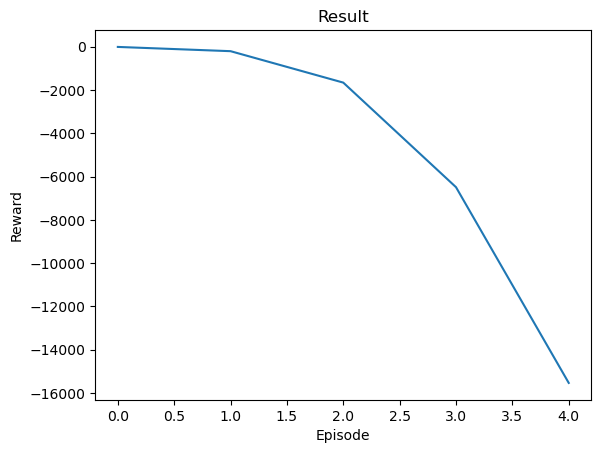

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [10]:
from tqdm import tqdm

if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 5
else:
    num_episodes = 5

pbar = tqdm(range(num_episodes), desc="Training Progress")

for i_episode in pbar:
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action)
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            episode_rewards.append(reward)
            pbar.set_postfix({
            'Episode Reward': f'{float(reward):.5f}',
        })
            # plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [11]:
env.pos

tensor([    94.7338,     84.4152, -15555.0752], device='mps:0')